<center><h1>In the name of Allah</h1></center>

**Subject: Predict a child's IQ from his mother's age at childbirth**

Import Tools

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load Datasets

In [309]:
# child_df = pd.read_csv('data/child_iq.csv')
kid_df = pd.read_csv('data/kid_iq.csv')

In [310]:
# child_df = child_df.drop(['Unnamed: 0'],axis=1)
kid_df = kid_df.drop(['Unnamed: 0'], axis=1)

EDA

In [311]:
kid_df.head(10)

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
5,98,0,107.901838,1,18
6,69,1,138.893106,4,20
7,106,1,125.145119,3,23
8,102,1,81.619526,1,24
9,95,1,95.073069,1,19


In [312]:
kid_df.describe()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
count,434.000000,434.000000,434.000000,434.000000,434.000000
mean,86.797235,0.785714,100.000000,2.896313,22.785714
std,20.410688,0.410799,15.000000,1.181394,2.701070
min,20.000000,0.000000,71.037405,1.000000,17.000000
25%,74.000000,1.000000,88.660321,2.000000,21.000000
50%,90.000000,1.000000,97.915254,3.000000,23.000000
75%,102.000000,1.000000,110.272742,4.000000,25.000000
max,144.000000,1.000000,138.893106,4.000000,29.000000


In [313]:
kid_df.duplicated().sum()

1

In [314]:
kid_df = kid_df.drop_duplicates()

In [315]:
kid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   kid_score  433 non-null    int64  
 1   mom_hs     433 non-null    int64  
 2   mom_iq     433 non-null    float64
 3   mom_work   433 non-null    int64  
 4   mom_age    433 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 20.3 KB


In [316]:
kid_df['mom_hs'].value_counts()

mom_hs
1    340
0     93
Name: count, dtype: int64

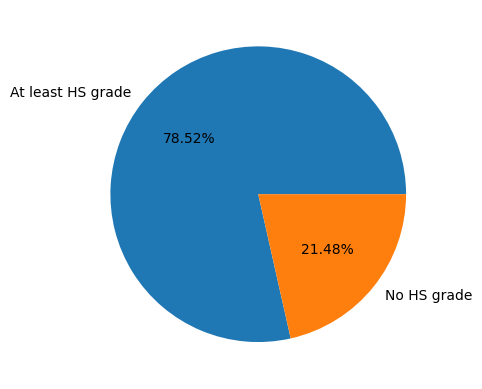

In [317]:
plt.figure()
plt.pie(kid_df['mom_hs'].value_counts(),labels=['At least HS grade','No HS grade'],autopct='%.2f%%');

In [318]:
kid_df['mom_work'].value_counts()

mom_work
4    204
2     96
1     77
3     56
Name: count, dtype: int64

In [319]:
kid_df['mom_work'] = kid_df['mom_work'].astype('category')
kid_df['mom_hs'] = kid_df['mom_hs'].astype('category')

In [320]:
kid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   kid_score  433 non-null    int64   
 1   mom_hs     433 non-null    category
 2   mom_iq     433 non-null    float64 
 3   mom_work   433 non-null    category
 4   mom_age    433 non-null    int64   
dtypes: category(2), float64(1), int64(2)
memory usage: 14.7 KB


<Figure size 1500x1500 with 0 Axes>

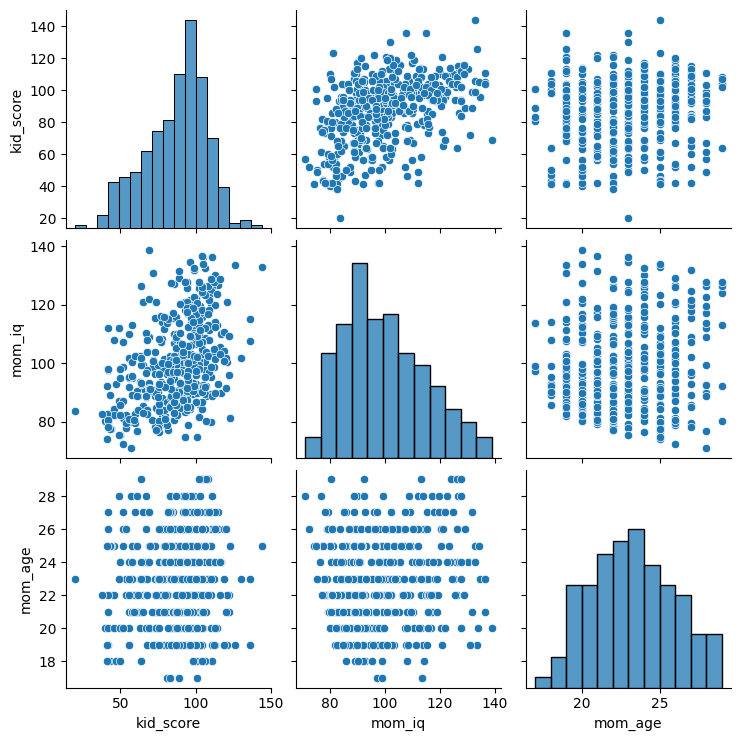

In [321]:
plt.figure(figsize=(15,15));
sns.pairplot(kid_df);

<Axes: >

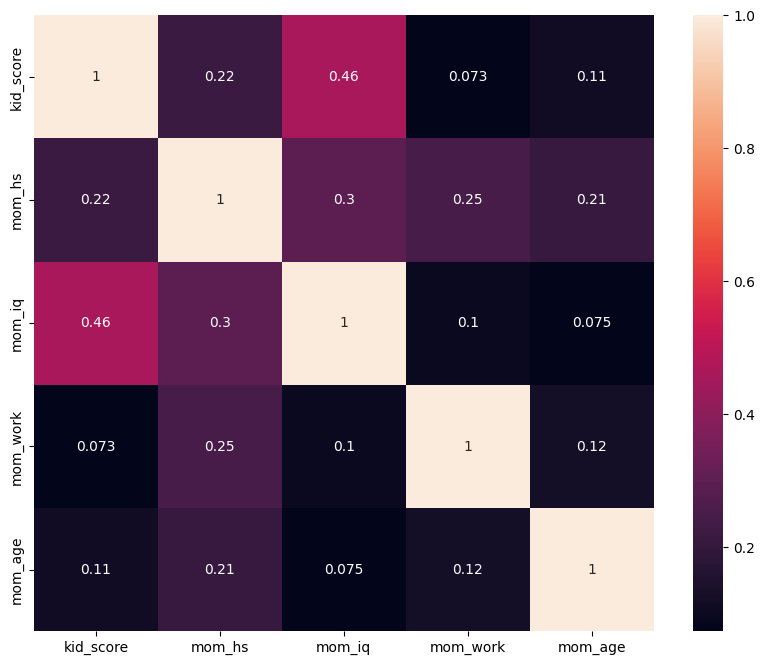

In [322]:
plt.figure(figsize=(10,8))
sns.heatmap(kid_df.corr(method = 'spearman'), annot=True)

Preprocessing

In [323]:
X = kid_df.drop('kid_score', axis=1)
y = kid_df['kid_score']

In [324]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = kid_df[['mom_work','mom_hs']], random_state=42, shuffle=True)

In [325]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [326]:
from sklearn.preprocessing import OneHotEncoder
one_hot_enc = OneHotEncoder(sparse_output=False)
train_encoded = pd.DataFrame(one_hot_enc.fit_transform(
    X_train['mom_work'].to_numpy().reshape(-1, 1))).add_prefix('mom_work_')

In [327]:
mom_hs_train = X_train['mom_hs']
X_train = X_train.drop(['mom_work','mom_hs'], axis=1)

In [328]:
from sklearn.preprocessing import MinMaxScaler
std_scaler = MinMaxScaler()
X_train = std_scaler.fit_transform(X_train)

In [329]:
X_train = pd.DataFrame(X_train, columns=['mom_iq', 'mom_age'])

In [330]:
X_train = pd.concat([X_train, mom_hs_train, train_encoded], axis=1)

In [331]:
test_encoded = pd.DataFrame(one_hot_enc.transform(X_test['mom_work'].to_numpy().reshape(-1, 1))).add_prefix('mom_work_')

In [332]:
mom_hs_test = X_test['mom_hs']
X_test = X_test.drop(['mom_work','mom_hs'], axis=1)

In [333]:
X_test = std_scaler.transform(X_test)

In [334]:
X_test = pd.DataFrame(X_test, columns=['mom_iq','mom_age'])

In [335]:
X_test = pd.concat([X_test, mom_hs_test, test_encoded], axis=1)

Modeling

DT

In [336]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor(random_state=42)
params = {'max_depth': [2, 4, 6, 10, 15, 20],
          'min_samples_split': [2, 5, 7, 10, 15, 20, 30],
          'min_samples_leaf': [2, 4, 7, 9, 12, 15]}

grid = GridSearchCV(estimator=dt, param_grid=params,
                    scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 15, 20],
                         'min_samples_leaf': [2, 4, 7, 9, 12, 15],
                         'min_samples_split': [2, 5, 7, 10, 15, 20, 30]},
             scoring='neg_mean_squared_error')

In [337]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [338]:
grid.best_score_

-362.73373320745884

In [339]:
best_dt_mdl = grid.best_estimator_

In [340]:
yhat_train = best_dt_mdl.predict(X_train)

In [341]:
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train, yhat_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, yhat_train)
print(f'{mse_train = }, {rmse_train = }, {r2_train = }')

mse_train = 254.48332785668939, rmse_train = 15.952533587386343, r2_train = 0.39382005916741447


RF

In [342]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)
params = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 6, 10, 20],
    'min_samples_split': [2, 10, 15, 20],
    'min_samples_leaf': [4, 9, 12, 15]}

grid = GridSearchCV(estimator=rf, param_grid=params,
                    scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 6, 10, 20],
                         'min_samples_leaf': [4, 9, 12, 15],
                         'min_samples_split': [2, 10, 15, 20],
                         'n_estimators': [5, 10, 20]},
             scoring='neg_mean_squared_error')

In [343]:
grid.best_params_

{'max_depth': 2,
 'min_samples_leaf': 12,
 'min_samples_split': 2,
 'n_estimators': 5}

In [344]:
grid.best_score_

-336.631987899845

In [345]:
best_rf_mdl = grid.best_estimator_

In [346]:
yhat_train = best_rf_mdl.predict(X_train)

In [347]:
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train, yhat_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, yhat_train)
print(f'{mse_train = }, {rmse_train = }, {r2_train = }')

mse_train = 319.19672729588996, rmse_train = 17.866077557647902, r2_train = 0.23967257542647147


Linear Regression

In [348]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)

In [349]:
lr.coef_

array([ 3.59434180e+01,  2.25285451e+00,  6.29341319e+00, -7.66944047e+13,
       -7.66944047e+13, -7.66944047e+13, -7.66944047e+13])

In [350]:
lr.intercept_

76694404720448.05

In [351]:
yhat_train = lr.predict(X_train)

In [352]:
from sklearn.metrics import mean_squared_error, r2_score
mse_train = mean_squared_error(y_train, yhat_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, yhat_train)
print(f'{mse_train = }, {rmse_train = }, {r2_train = }')

mse_train = 330.0301372550126, rmse_train = 18.166731606291005, r2_train = 0.21386736506811632
